In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import matplotlib.style as style
style.use('ggplot')

In [2]:
df_sales = pd.read_csv('data/Alcohol_Sales.csv', index_col='DATE', parse_dates=True)
df_sales.index.freq = 'MS'

In [3]:
df_sales.index.max()

Timestamp('2019-12-01 00:00:00', freq='MS')

In [4]:
def ts_train_test_split(data, split_date):
    '''
    Split time series into training and test data
    
    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series
    
    Returns:
    --------
    tuple (len=2) 
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    '''
    train = data.loc[data.index < split_date]
    test = data.loc[data.index >= split_date]
    return train, test

In [5]:
train, test = ts_train_test_split(df_sales, '2019-10-01')

In [6]:
test.shape

(3, 1)

In [7]:
train.shape

(333, 1)

[Text(0, 0.5, 'Millions of dollars')]

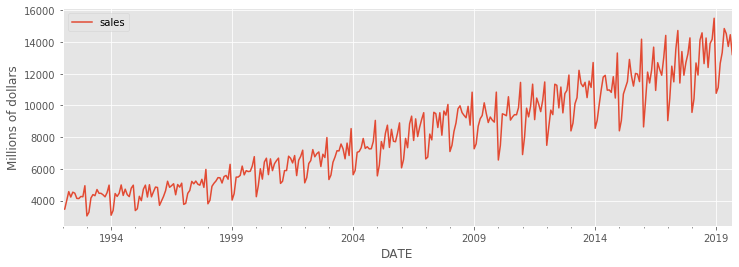

In [8]:
ax = train.plot(figsize=(12,4))
ax.set(ylabel='Millions of dollars')

In [9]:
ax.figure.savefig('images/all_alcohol_sales.png', dpi=300, bbox_inches='tight', format='png')

[Text(0, 0.5, 'Millions of dollars')]

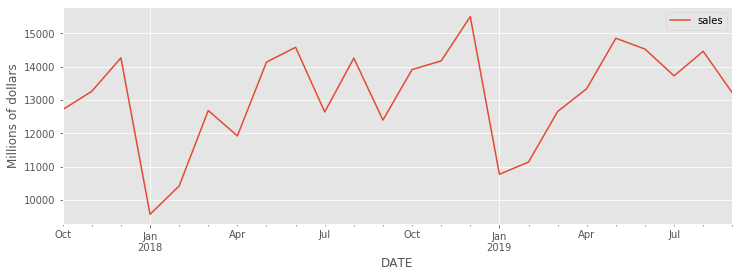

In [10]:
ax = train[-24:].plot(figsize=(12,4))
ax.set(ylabel='Millions of dollars')

In [11]:
ax.figure.savefig('images/last24_alcohol_sales.png', dpi=300, bbox_inches='tight', format='png')

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [13]:
sd_result = seasonal_decompose(train, model='multiplicative')

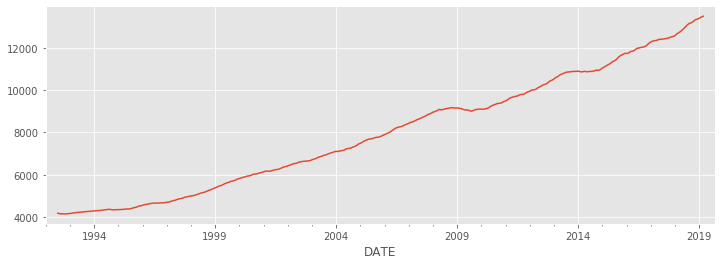

In [14]:
ax = sd_result.trend.plot(figsize=(12,4))

In [15]:
ax.figure.savefig('images/trend.png', dpi=300, bbox_inches='tight', format='png')

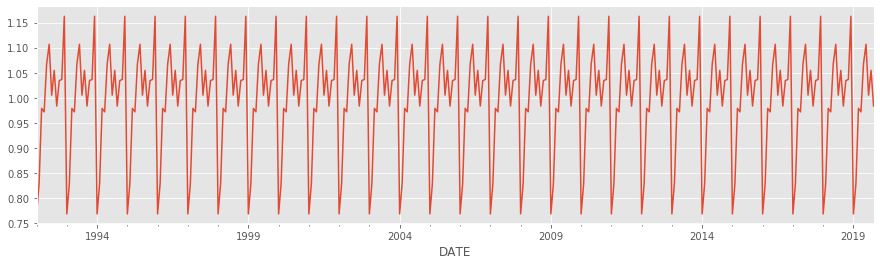

In [16]:
ax = sd_result.seasonal.plot(figsize=(15,4))

In [17]:
ax.figure.savefig('images/seasonality.png', dpi=300, bbox_inches='tight', format='png')

In [18]:
train.shape

(333, 1)

In [19]:
train.index.min()

Timestamp('1992-01-01 00:00:00', freq='MS')

In [20]:
from pmdarima.datasets import load_airpassengers

In [43]:
START_DATE = '1949-01-01'
airline = load_airpassengers(as_series=True)

#there's no datetimeindex from the bundled dataset. So let's add one.
airline.index= pd.date_range(START_DATE, periods=len(airline), freq='MS')

In [44]:
from pmdarima import auto_arima

In [45]:
airline_adj = pd.Series(np.log(airline))

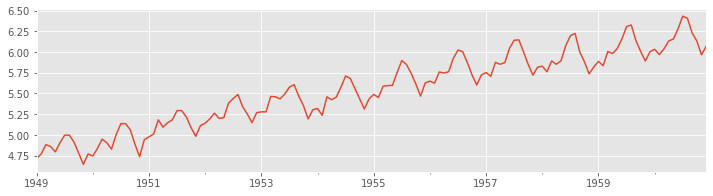

In [46]:
airline_adj.plot(figsize=(12,3))

In [47]:
results = auto_arima(airline_adj, m=12)

/Users/thomasmonks/opt/anaconda3/envs/psma/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/thomasmonks/opt/anaconda3/envs/psma/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/thomasmonks/opt/anaconda3/envs/psma/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/thomasmonks/opt/anaconda3/envs/psma/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/thomasmonks/opt/anaconda3/envs/psma/lib/python3.7/sit

In [48]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  144
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 249.647
Date:                              Sat, 21 Mar 2020   AIC                           -489.294
Time:                                      17:02:56   BIC                           -474.880
Sample:                                           0   HQIC                          -483.437
                                              - 144                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0191      0.008      2.313      0.021       0.003       0.035
ar.L1          0.5769      0.075      7.670      0.000       0.429       0.724
ar.L2          0.2620      0.084      3.124      0.002       0.098       0.426
ma.S.L12      -0.5571      0.106     -5.260      0.000      -0.765      -0.350
sigma2         0.0013      0.000      8.861      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       42.49   Jarque-Bera (JB):                 6.36
Prob(Q):                              0.36   Prob(JB):                         0.04
Heteroskedasticity (H):               0.58   Skew:                             0.07
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
def preds_as_series(data, preds):
    '''
    Helper function for plotting predictions.
    Converts a numpy array of predictions to a 
    pandas.DataFrame with datetimeindex
    
    Parameters
    -----
    preds - numpy.array, vector of predictions
    start - start date of the time series
    freq - the frequency of the time series e.g 'MS' or 'D'
    '''
    start = pd.date_range(start=data.index.max(), periods=2, freq=data.index.freq).max()
    idx = pd.date_range(start=start, periods=len(preds), freq=data.index.freq)
    return pd.DataFrame(preds, index=idx)

In [59]:
def plot_prediction_intervals(train, preds, intervals_80, intervals_90,
                              test=None):
    '''
    Helper function to plot training data, point preds
    and 2 sets of prediction intevals
    
    assume 2 sets of PIs are provided!
    '''
    ax = train.plot(figsize=(12,4))

    mean = preds_as_series(train, preds)
    intervals_80 = preds_as_series(train, intervals_80)
    intervals_90 = preds_as_series(train, intervals_90)

    mean.plot(ax=ax, label='point forecast')

    ax.fill_between(intervals_80.index, mean[0], intervals_80[1], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,mean[0], intervals_80[0], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,intervals_80[1], intervals_90[1], 
                    alpha=0.2,
                    label='90% PI', color='purple');

    ax.fill_between(intervals_80.index,intervals_80[0], intervals_90[0], 
                    alpha=0.2,
                    label='90% PI', color='purple');
    
    if test is None:
        ax.legend(['train', 'point forecast', '80%PI', '_ignore','_ignore', '90%PI'], loc=2)
    else:
        test.plot(ax=ax, color='black')
        ax.legend(['train', 'point forecast', 'Test', '80%PI', '_ignore','_ignore', '90%PI'], loc=2)
    
    return ax

In [69]:
preds, intervals_90 = results.predict(48, return_conf_int=True, alpha=0.1)
preds, intervals_80 = results.predict(48, return_conf_int=True, alpha=0.2)
intervals_80 = np.exp(intervals_80)
intervals_90 = np.exp(intervals_90)
preds = np.exp(preds)

/Users/thomasmonks/opt/anaconda3/envs/psma/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x1a1acefcc0> has a label of '_ignore' which cannot be automatically added to the legend.
/Users/thomasmonks/opt/anaconda3/envs/psma/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x1a1acef048> has a label of '_ignore' which cannot be automatically added to the legend.


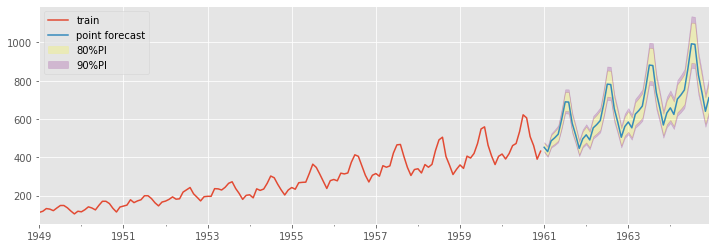

In [74]:
ax = plot_prediction_intervals(airline, preds, intervals_80, intervals_90)

In [75]:
ax.figure.savefig('images/ap_forecast.png', dpi=200, bbox_inches='tight')